# Fully Connected Network testing on CIFAR data

In [46]:
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from src.network.multilayernetwork import MLP
from src.utils.data_utils import get_CIFAR10_data
from src.utils.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from src.train.solver import Solver
from src.activation import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def print_mean_std(x,axis=0):
    print('  means: ', x.mean(axis=axis))
    print('  stds:  ', x.std(axis=axis))
    print() 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in list(data.items()):
  print(('%s: ' % k, v.shape))

('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


In [3]:
# Affine Forward
# Test the affine_backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around e-10 or less
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  6.986348504372948e-11
dw error:  9.904023583987626e-11
db error:  7.736978834487815e-12


In [4]:
# Affine backward
# Test the affine_backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around e-10 or less
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  6.986348504372948e-11
dw error:  9.904023583987626e-11
db error:  7.736978834487815e-12


In [90]:
# Relu forward
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be on the order of e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


In [91]:
# Relu backward
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be on the order of e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756349136310288e-12


# Initial Loss and gradient check

In [32]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = MLP([H1, H2], input_dim=D, num_classes=C, reg=reg, 
              weight_scale=5e-2, dtype=np.float64)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)
  
  # Most of the errors should be on the order of e-7 or smaller.   
  # NOTE: It is fine however to see an error for W2 on the order of e-5
  # for the check when reg = 0.0
  for l in range(len(model.layers)):
    name_W = 'W%d'%(l+1)
    name_b = 'b%d'%(l+1)
    f = lambda _: model.loss(X,y)[0]
    layer = model.layers[l]
    grad_num = eval_numerical_gradient(f, layer.W, verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name_W, rel_error(grad_num, grads[name_W])))
    grad_num = eval_numerical_gradient(f, layer.b, verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name_b, rel_error(grad_num, grads[name_b])))

Running check with reg =  0
Initial loss:  2.3004790897684924
W1 relative error: 1.48e-07
b1 relative error: 5.38e-09
W2 relative error: 2.21e-05
b2 relative error: 2.09e-09
W3 relative error: 3.53e-07
b3 relative error: 5.80e-11
Running check with reg =  3.14
Initial loss:  7.052114776533016
W1 relative error: 3.90e-09
b1 relative error: 1.48e-08
W2 relative error: 6.87e-08
b2 relative error: 1.72e-09
W3 relative error: 2.13e-08
b3 relative error: 1.57e-10


Also run solver on a 3-layer fully-connected network

(Iteration 1 / 40) loss: 2.305053
(Epoch 0 / 20) train acc: 0.300000; val_acc: 0.125000
(Epoch 1 / 20) train acc: 0.380000; val_acc: 0.161000
(Epoch 2 / 20) train acc: 0.320000; val_acc: 0.173000
(Epoch 3 / 20) train acc: 0.540000; val_acc: 0.155000
(Epoch 4 / 20) train acc: 0.640000; val_acc: 0.182000
(Epoch 5 / 20) train acc: 0.580000; val_acc: 0.202000
(Iteration 11 / 40) loss: 0.965491
(Epoch 6 / 20) train acc: 0.720000; val_acc: 0.161000
(Epoch 7 / 20) train acc: 0.840000; val_acc: 0.217000
(Epoch 8 / 20) train acc: 0.840000; val_acc: 0.163000
(Epoch 9 / 20) train acc: 0.960000; val_acc: 0.199000
(Epoch 10 / 20) train acc: 0.960000; val_acc: 0.191000
(Iteration 21 / 40) loss: 0.224380
(Epoch 11 / 20) train acc: 0.980000; val_acc: 0.207000
(Epoch 12 / 20) train acc: 0.980000; val_acc: 0.198000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.215000
(Epoch 14 / 20) train acc: 0.980000; val_acc: 0.185000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.210000
(Iteration 31 / 40) loss: 

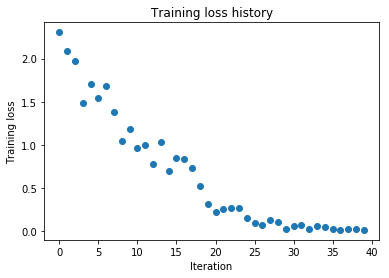

In [35]:
# TODO: Use a three-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 1e-2
learning_rate = 1e-2
model = MLP([100, 100],
              weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

Try to achieve 100 percent training using a 5-layer network

(Iteration 1 / 40) loss: 2.403874
(Epoch 0 / 20) train acc: 0.280000; val_acc: 0.085000
(Epoch 1 / 20) train acc: 0.260000; val_acc: 0.119000
(Epoch 2 / 20) train acc: 0.460000; val_acc: 0.139000
(Epoch 3 / 20) train acc: 0.680000; val_acc: 0.135000
(Epoch 4 / 20) train acc: 0.660000; val_acc: 0.111000
(Epoch 5 / 20) train acc: 0.840000; val_acc: 0.128000
(Iteration 11 / 40) loss: 0.849178
(Epoch 6 / 20) train acc: 0.860000; val_acc: 0.145000
(Epoch 7 / 20) train acc: 0.820000; val_acc: 0.155000
(Epoch 8 / 20) train acc: 0.680000; val_acc: 0.134000
(Epoch 9 / 20) train acc: 0.880000; val_acc: 0.130000
(Epoch 10 / 20) train acc: 0.980000; val_acc: 0.162000
(Iteration 21 / 40) loss: 0.406603
(Epoch 11 / 20) train acc: 0.980000; val_acc: 0.151000
(Epoch 12 / 20) train acc: 0.940000; val_acc: 0.153000
(Epoch 13 / 20) train acc: 0.960000; val_acc: 0.147000
(Epoch 14 / 20) train acc: 0.980000; val_acc: 0.151000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.152000
(Iteration 31 / 40) loss: 

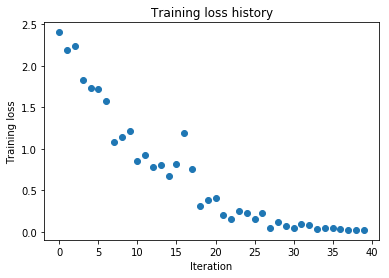

In [36]:
# TODO: Use a five-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

learning_rate = .021
weight_scale = .036
model = MLP([100, 100, 100, 100],
                weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

# Adding momentum to SGD

In [42]:
from src.train.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

# Should see relative errors around e-8 or less
print('next_w error: %.2e'% rel_error(next_w, expected_next_w))
print('velocity error: %.2e'% rel_error(expected_velocity, config['velocity']))

next_w error: 1.00e+00
velocity error: 1.00e+00


Train 6 layer network and compare SGD vs SGD with momentum. We expect SGD with momentum to converge faster.

running with  sgd
(Iteration 1 / 200) loss: 2.691828
(Epoch 0 / 5) train acc: 0.094000; val_acc: 0.096000
(Iteration 11 / 200) loss: 2.283556
(Iteration 21 / 200) loss: 2.122774
(Iteration 31 / 200) loss: 2.041229
(Epoch 1 / 5) train acc: 0.232000; val_acc: 0.241000
(Iteration 41 / 200) loss: 2.150449
(Iteration 51 / 200) loss: 1.961330
(Iteration 61 / 200) loss: 2.063275
(Iteration 71 / 200) loss: 2.032266
(Epoch 2 / 5) train acc: 0.321000; val_acc: 0.296000
(Iteration 81 / 200) loss: 1.928428
(Iteration 91 / 200) loss: 1.800821
(Iteration 101 / 200) loss: 1.728299
(Iteration 111 / 200) loss: 1.741138
(Epoch 3 / 5) train acc: 0.372000; val_acc: 0.313000
(Iteration 121 / 200) loss: 1.839617
(Iteration 131 / 200) loss: 1.743168
(Iteration 141 / 200) loss: 1.894777
(Iteration 151 / 200) loss: 1.733322
(Epoch 4 / 5) train acc: 0.402000; val_acc: 0.311000
(Iteration 161 / 200) loss: 1.806937
(Iteration 171 / 200) loss: 1.711685
(Iteration 181 / 200) loss: 1.714899
(Iteration 191 / 200) los

/Users/johannlingohr/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


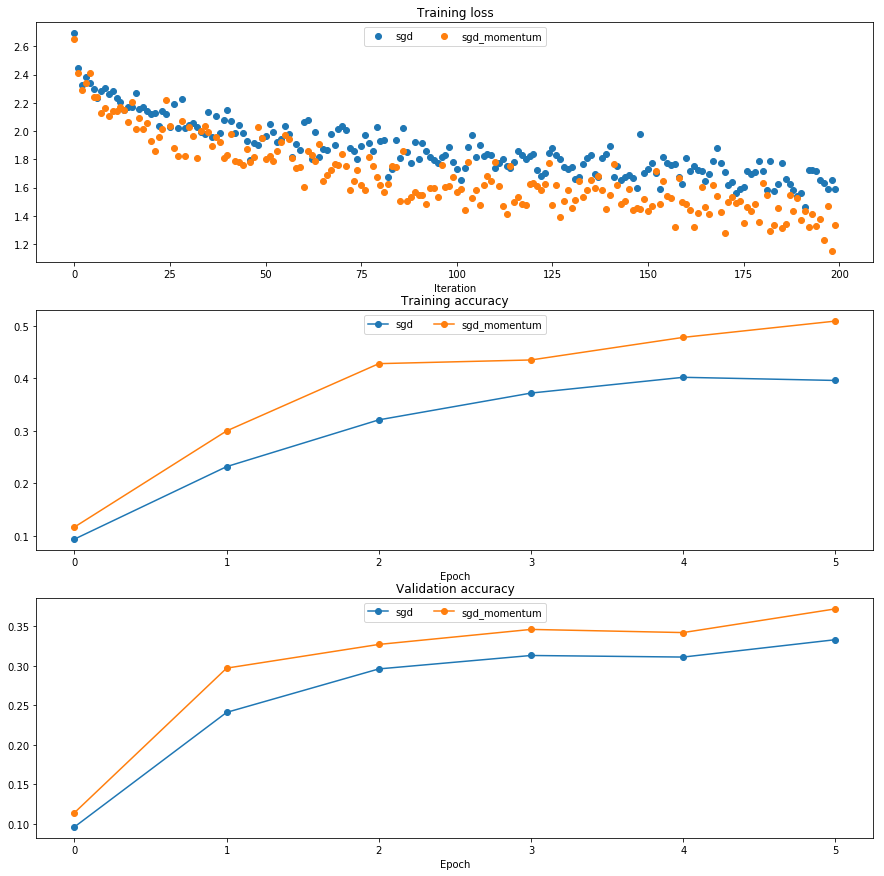

In [52]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
  print('running with ', update_rule)
  model = MLP([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': 1e-2,
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# RMSProp and Adam

In [16]:
# Test RMSProp implementation
from src.train.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  9.502645229894295e-08
cache error:  2.6477955807156126e-09


In [17]:
# Test Adam implementation
from src.train.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

next_w error:  1.1395691798535431e-07
v error:  4.208314038113071e-09
m error:  4.214963193114416e-09


Train networks using RMSProp and Adagrad

running with  adam
(Iteration 1 / 200) loss: 2.894420
(Epoch 0 / 5) train acc: 0.117000; val_acc: 0.121000
(Iteration 11 / 200) loss: 2.061541
(Iteration 21 / 200) loss: 1.902564
(Iteration 31 / 200) loss: 1.713988
(Epoch 1 / 5) train acc: 0.401000; val_acc: 0.336000
(Iteration 41 / 200) loss: 1.655770
(Iteration 51 / 200) loss: 1.722452
(Iteration 61 / 200) loss: 1.849499
(Iteration 71 / 200) loss: 1.766855
(Epoch 2 / 5) train acc: 0.452000; val_acc: 0.348000
(Iteration 81 / 200) loss: 1.571622
(Iteration 91 / 200) loss: 1.570279
(Iteration 101 / 200) loss: 1.524782
(Iteration 111 / 200) loss: 1.332907
(Epoch 3 / 5) train acc: 0.536000; val_acc: 0.368000
(Iteration 121 / 200) loss: 1.455248
(Iteration 131 / 200) loss: 1.428043
(Iteration 141 / 200) loss: 1.383883
(Iteration 151 / 200) loss: 1.495937
(Epoch 4 / 5) train acc: 0.556000; val_acc: 0.355000
(Iteration 161 / 200) loss: 1.145257
(Iteration 171 / 200) loss: 1.329834
(Iteration 181 / 200) loss: 1.407794
(Iteration 191 / 200) lo

/Users/johannlingohr/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


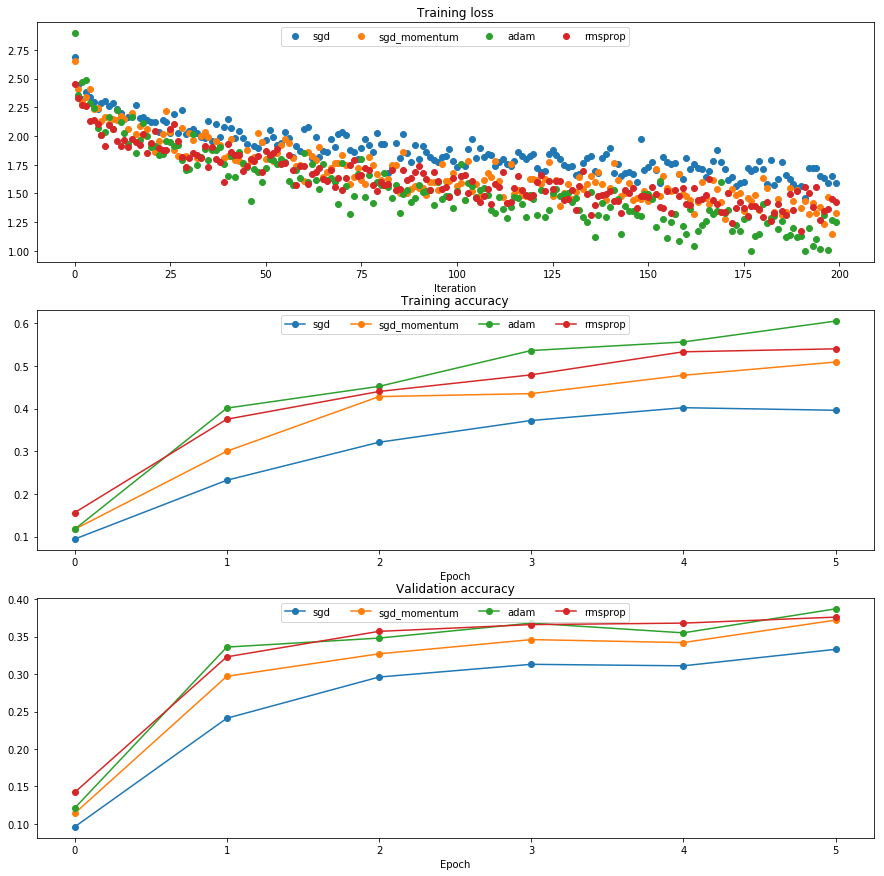

In [66]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
  print('running with ', update_rule)
  model = MLP([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': learning_rates[update_rule]
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

Train a fully connected network on CIFAR dataset

In [92]:
best_modelbest_mo  = None
weight_scale = 5e-2
learning_rate = 1e-3 
model = MLP([100, 100, 100, 100],
              weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, data,
                print_every=100, num_epochs=5, batch_size=200,
                update_rule='adam',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

# accuracy should be about 51%. 
best_model = model 

(Iteration 1 / 1225) loss: 3.337674
(Epoch 0 / 5) train acc: 0.095000; val_acc: 0.099000
(Iteration 101 / 1225) loss: 1.709591
(Iteration 201 / 1225) loss: 1.702135
(Epoch 1 / 5) train acc: 0.403000; val_acc: 0.441000
(Iteration 301 / 1225) loss: 1.523707
(Iteration 401 / 1225) loss: 1.481704
(Epoch 2 / 5) train acc: 0.495000; val_acc: 0.452000
(Iteration 501 / 1225) loss: 1.543950
(Iteration 601 / 1225) loss: 1.390782
(Iteration 701 / 1225) loss: 1.324571
(Epoch 3 / 5) train acc: 0.480000; val_acc: 0.488000
(Iteration 801 / 1225) loss: 1.332988
(Iteration 901 / 1225) loss: 1.377445
(Epoch 4 / 5) train acc: 0.491000; val_acc: 0.474000
(Iteration 1001 / 1225) loss: 1.366343
(Iteration 1101 / 1225) loss: 1.369705
(Iteration 1201 / 1225) loss: 1.307343
(Epoch 5 / 5) train acc: 0.547000; val_acc: 0.516000


In [93]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.516
Test set accuracy:  0.499


# Batch Normalization
Test implementation of forward pass with batch normalization

In [119]:
# Check the training-time forward pass by checking means and variances
# of features both before and after batch normalization   

# Simulate the forward pass for a two-layer network
np.random.seed(231)
N, D1, D2, D3 = 200, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)

print('Before batch normalization:')
print_mean_std(a,axis=0)

gamma = np.ones((D3,))
beta = np.zeros((D3,))
# Means should be close to zero and stds close to one
print('After batch normalization (gamma=1, beta=0)')
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,axis=0)

gamma = np.asarray([1.0, 2.0, 3.0])
beta = np.asarray([11.0, 12.0, 13.0])
# Now means should be close to beta and stds close to gamma
print('After batch normalization (gamma=', gamma, ', beta=', beta, ')')
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,axis=0)

Before batch normalization:
  means:  [ -2.3814598  -13.18038246   1.91780462]
  stds:   [27.18502186 34.21455511 37.68611762]

After batch normalization (gamma=1, beta=0)
  means:  [ 4.21884749e-17  5.10702591e-17 -3.51801921e-17]
  stds:   [0.99999999 1.         1.        ]

After batch normalization (gamma= [1. 2. 3.] , beta= [11. 12. 13.] )
  means:  [11. 12. 13.]
  stds:   [0.99999999 1.99999999 2.99999999]



Test implementation of backwards pass with batch normalization

In [94]:
# Gradient check batchnorm backward pass
np.random.seed(231)
N, D = 4, 5
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
fx = lambda x: batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: batchnorm_forward(x, a, beta, bn_param)[0]
fb = lambda b: batchnorm_forward(x, gamma, b, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma.copy(), dout)
db_num = eval_numerical_gradient_array(fb, beta.copy(), dout)

_, cache = batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = batchnorm_backward(dout, cache)
#You should expect to see relative errors between 1e-13 and 1e-8
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  1.702922567450423e-09
dgamma error:  7.420414216247087e-13
dbeta error:  2.8795057655839487e-12


## Fully Connected Nets with Batch Normalization
When the `normalization` flag is set to `"batchnorm"` in the constructor, insert a batch normalization layer before each ReLU nonlinearity. The outputs from the last layer of the network should not be normalized.

In [102]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

# You should expect losses between 1e-4~1e-10 for W, 
# losses between 1e-08~1e-10 for b,
# and losses between 1e-08~1e-09 for beta and gammas.
for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = MLP([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64,
                            normalization='batchnorm')

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params()[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
  if reg == 0: print()

Running check with reg =  0
Initial loss:  2.2611955101340957
W1 relative error: 1.10e-04
W2 relative error: 2.85e-06
W3 relative error: 3.92e-10
b1 relative error: 1.05e-08
b2 relative error: 7.81e-09
b3 relative error: 1.01e-10
beta1 relative error: 2.99e-10
beta2 relative error: 2.48e-10
gamma1 relative error: 4.22e-09
gamma2 relative error: 1.18e-10

Running check with reg =  3.14
Initial loss:  6.996533220108303
W1 relative error: 1.98e-06
W2 relative error: 2.28e-06
W3 relative error: 1.11e-08
b1 relative error: 4.44e-08
b2 relative error: 8.41e-09
b3 relative error: 2.23e-10
beta1 relative error: 3.25e-09
beta2 relative error: 1.25e-11
gamma1 relative error: 2.50e-09
gamma2 relative error: 9.12e-11


# BatchNorm for deep neural nets
Run the following to train a six-layer network on a subset of 1000 training examples both with and without batch normalization.

In [106]:
np.random.seed(231)
# Try training a very deep net with batchnorm
hidden_dims = [100, 100, 100, 100, 100]

num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 2e-2
bn_model = MLP(hidden_dims, weight_scale=weight_scale, normalization='batchnorm')
model = MLP(hidden_dims, weight_scale=weight_scale, normalization=None)

bn_solver = Solver(bn_model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True,print_every=20)
bn_solver.train()

solver = Solver(model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=20)
solver.train()

(Iteration 1 / 200) loss: 2.340974
(Epoch 0 / 10) train acc: 0.107000; val_acc: 0.115000
(Epoch 1 / 10) train acc: 0.305000; val_acc: 0.256000
(Iteration 21 / 200) loss: 2.036259
(Epoch 2 / 10) train acc: 0.384000; val_acc: 0.281000
(Iteration 41 / 200) loss: 2.029962
(Epoch 3 / 10) train acc: 0.496000; val_acc: 0.312000
(Iteration 61 / 200) loss: 1.707219
(Epoch 4 / 10) train acc: 0.536000; val_acc: 0.283000
(Iteration 81 / 200) loss: 1.313740
(Epoch 5 / 10) train acc: 0.556000; val_acc: 0.306000
(Iteration 101 / 200) loss: 1.249723
(Epoch 6 / 10) train acc: 0.655000; val_acc: 0.323000
(Iteration 121 / 200) loss: 1.130296
(Epoch 7 / 10) train acc: 0.677000; val_acc: 0.324000
(Iteration 141 / 200) loss: 1.240200
(Epoch 8 / 10) train acc: 0.676000; val_acc: 0.315000
(Iteration 161 / 200) loss: 0.782968
(Epoch 9 / 10) train acc: 0.754000; val_acc: 0.343000
(Iteration 181 / 200) loss: 0.913700
(Epoch 10 / 10) train acc: 0.788000; val_acc: 0.308000
(Iteration 1 / 200) loss: 2.302332
(Epoch

Run the following to visualize the results from two networks trained above. You should find that using batch normalization helps the network to converge much faster.

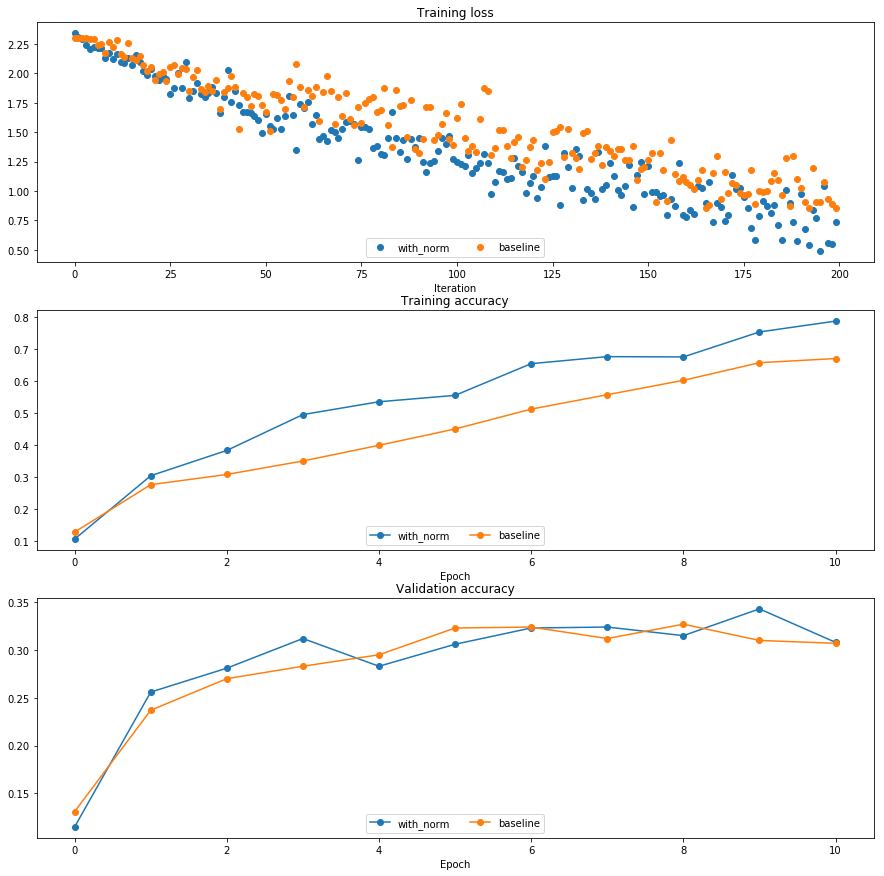

In [107]:
def plot_training_history(title, label, baseline, bn_solvers, plot_fn, bl_marker='.', bn_marker='.', labels=None):
    """utility function for plotting training history"""
    plt.title(title)
    plt.xlabel(label)
    bn_plots = [plot_fn(bn_solver) for bn_solver in bn_solvers]
    bl_plot = plot_fn(baseline)
    num_bn = len(bn_plots)
    for i in range(num_bn):
        label='with_norm'
        if labels is not None:
            label += str(labels[i])
        plt.plot(bn_plots[i], bn_marker, label=label)
    label='baseline'
    if labels is not None:
        label += str(labels[0])
    plt.plot(bl_plot, bl_marker, label=label)
    plt.legend(loc='lower center', ncol=num_bn+1) 

    
plt.subplot(3, 1, 1)
plot_training_history('Training loss','Iteration', solver, [bn_solver], \
                      lambda x: x.loss_history, bl_marker='o', bn_marker='o')
plt.subplot(3, 1, 2)
plot_training_history('Training accuracy','Epoch', solver, [bn_solver], \
                      lambda x: x.train_acc_history, bl_marker='-o', bn_marker='-o')
plt.subplot(3, 1, 3)
plot_training_history('Validation accuracy','Epoch', solver, [bn_solver], \
                      lambda x: x.val_acc_history, bl_marker='-o', bn_marker='-o')

plt.gcf().set_size_inches(15, 15)
plt.show()